In [431]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib as mpl
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from astropy.cosmology import Planck15
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.optimize import minimize
from scipy.special import erfc
from classy import Class

sys.path.append('/Users/smsharma/heptools/colossus/')

from colossus.cosmology import cosmology
from colossus.lss import mass_function

from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast
from theory.kink import MassFunctionKink
from theory.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

# Vanilla scenario

## Compare linear power spectra between `CLASS` and `colossus`

In [350]:
from classy import Class

common_settings = {  # Background parameters
    'H0': 67.32117,
    'omega_b': 0.02238280,
    'N_ur': 2.03066666667,
    'omega_cdm': 0.1201075,
    'N_ncdm': 1,
    'omega_ncdm': 0.0006451439,
    'YHe': 0.2454006,
    'tau_reio': 0.05430842,
    'modes': 's',
    
    # Output settings
    'output': 'mPk',
    'P_k_max_1/Mpc': 2e4,
    'k_per_decade_for_pk':5,
    'k_per_decade_for_bao':20,
}

CLASS_inst = Class()
CLASS_inst.set(common_settings)
CLASS_inst.compute()

In [487]:
k_ary = np.logspace(-6, np.log10(1e2), 1000)
Pk_ary = np.array([CLASS_inst.pk_cb_lin(k,0) for k in k_ary])

log10_P_interp = interp1d(np.log10(k_ary), np.log10(Pk_ary), bounds_error=False, fill_value='extrapolate')

In [488]:
sys.path.append('/Users/smsharma/heptools/colossus/')

from colossus.cosmology import cosmology
from colossus.lss import mass_function

cosmo = cosmology.setCosmology('planck18')

In [489]:
h = CLASS_inst.h()

Text(0, 0.5, '$P(k)\\,\\mathrm{[Mpc]}^{3}$')

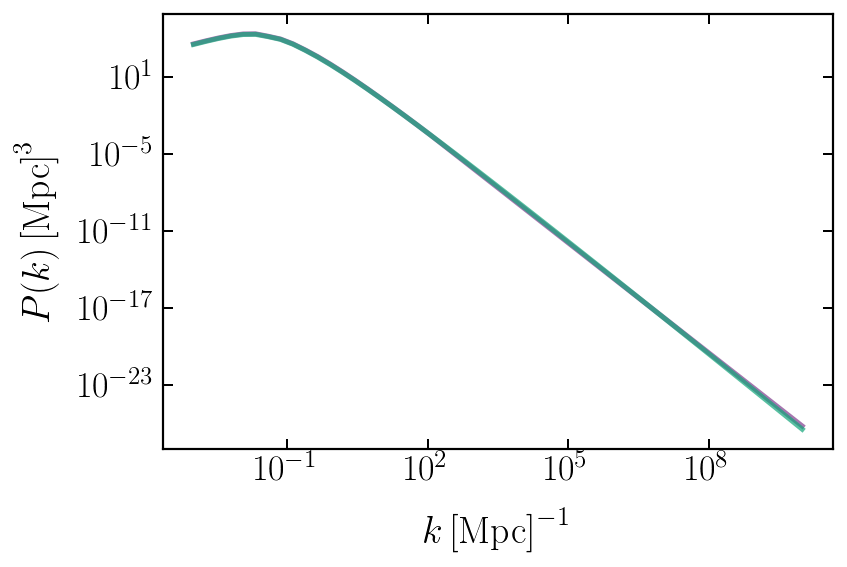

In [490]:
k_ary = np.logspace(-3, 10)  # Mpc^{-1}
pk_lin_class = [10 ** log10_P_interp(np.log10(k * h) )  * h ** 3 for k in k_ary]  # Mpc^3

plt.plot(k_ary, pk_lin_class)
plt.plot(k_ary, cosmo.matterPowerSpectrum(k_ary))

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$k\,\mathrm{[Mpc]}^{-1}$")
plt.ylabel("$P(k)\,\mathrm{[Mpc]}^{3}$")

## Compare $\sigma(M,z)$

In [491]:
def sigma_col(R, z=0):
    return cosmo.sigma(R, z)

def W(k, R):
    if k * R < 1e-3:
        return 1.
    else:
        return 3 * (k * R) ** -3 * (np.sin(k * R) - (k * R) * np.cos(k * R))

def log_integrand(lnk, R):
    k = np.exp(lnk)
    return (k ** 3 / (2 * np.pi ** 2)) * 10 ** log10_P_interp(np.log10(k * h) ) * h ** 3  * W(k, R) ** 2

def sigma_quad(R, kmax=10):
    return np.sqrt(quad(lambda lnk: log_integrand(lnk, R), np.log(10**-7), np.log(10**kmax), epsabs = 0.0, epsrel = 1e-2, limit = 100))[0]

Text(0.5, 0, '$R$\\,[Mpc/h]')

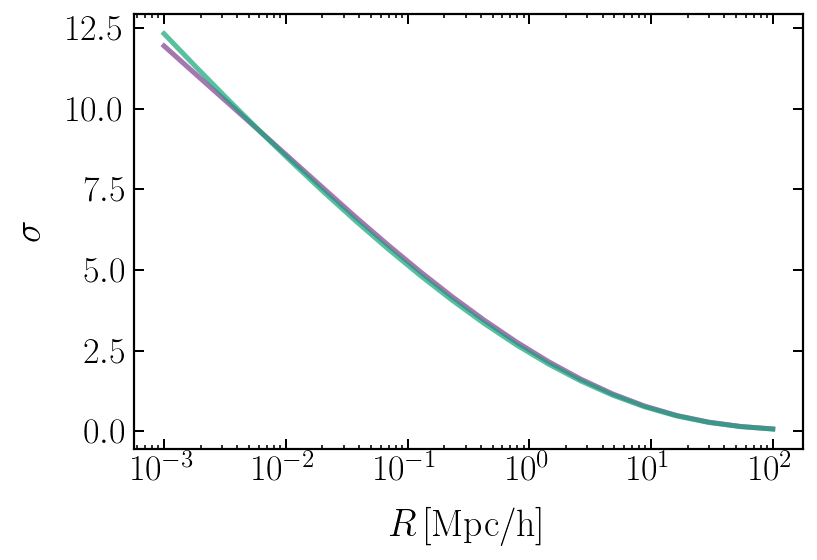

In [492]:
R_ary = np.logspace(-3, 2, 20)

plt.plot(R_ary, [sigma_quad(R, kmax=10) for R in R_ary])
plt.plot(R_ary, [sigma_col(R) for R in R_ary])

plt.xscale("log")

plt.ylabel("$\sigma$")
plt.xlabel("$R$\,[Mpc/h]")

## Densities

In [493]:
def D(z):
    '''
    Linear growth factor normalized to z=0. The mathematics follows from
    Equation 5 of arxiv.org/pdf/1309.5385.pdf
    Inputs:
    z: redshift (single value);
    Output:
    Linear growth factor
    '''

    gamma = 0.55
    f = lambda z: 1/(1+z)*(Planck15.Om(z))**0.55

    growth_factor = np.exp(-quad(f, 0, z, epsabs=0, epsrel=1e-10)[0])

    return growth_factor

def delta_sc(z):
    return delta_c / D(z)

# def D(z):
#     return cosmo.growthFactor(z)

In [494]:
def sigma(M200):
    R = (M200 / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.)
    return sigma_quad(R / (Mpc / h))
    
f = 0.02
C = 650.

n_iter_max = 100

z_coll_ary = np.zeros(n_iter_max)
c200_ary = np.zeros(n_iter_max)

z_coll_ary[0] = 0.1
c200_ary[0] = 10.

def c200_zcoll(M200):

    for i in range(1, n_iter_max):
        opt = minimize(lambda z_coll: np.abs(erfc((delta_sc(z_coll) - delta_sc(0)) / (np.sqrt(2 * (sigma(f * M200) ** 2 - sigma(M200) ** 2)))) - ((-1 + np.log(4)) / 2. / (-1 + 1 / (1 + c200_ary[i - 1]) + np.log(1 + c200_ary[i - 1])))), [10.], bounds=[[0.1,2000.]], method='SLSQP')
        z_coll_ary[i] = opt.x
        c200_ary[i] = minimize(lambda c200: np.abs(C * (Planck15.H(z_coll_ary[i]).value / Planck15.H0.value) ** 2 - (200. / 3. / 4. * c200 ** 3 / (np.log(1 + c200) - c200 / (1 + c200)))), [10.], bounds=[[1.,1e5]], method='SLSQP').x

        z_err = np.abs((z_coll_ary[i] - z_coll_ary[i - 1]) / z_coll_ary[i - 1])
        c200_err = np.abs((c200_ary[i] - c200_ary[i - 1]) / c200_ary[i - 1])

        if z_err < 0.01 and  c200_err < 0.01: break

    return c200_ary[i], z_coll_ary[i]

In [495]:
M_ary = np.logspace(6, 13, 10) * M_s
c200_ary_plot = [c200_zcoll(M)[0] for M in tqdm(M_ary)]

100%|██████████| 10/10 [00:43<00:00,  6.67s/it]


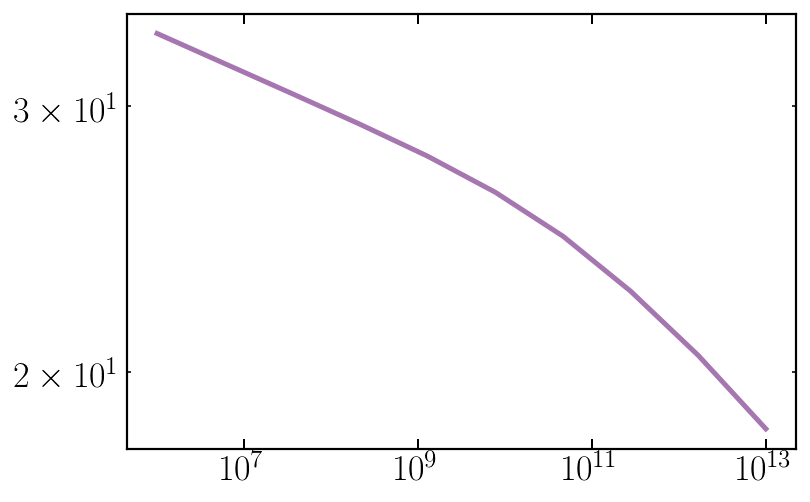

In [496]:
plt.plot(M_ary / M_s, c200_ary_plot)

plt.xscale("log")
plt.yscale("log")

# Kinky

## Generate `CLASS` instances with kinked spectra

In [499]:
mfk = MassFunctionKink()

n_B_list = [0.9655, 3.]

In [566]:
CLASS_inst_list = []
for n_B in tqdm(n_B_list):
    CLASS_inst = mfk.get_CLASS_kink(k_B=10.,n_B=n_B, k_max=1e3)
    CLASS_inst_list.append(CLASS_inst)

100%|██████████| 2/2 [01:13<00:00, 35.42s/it]


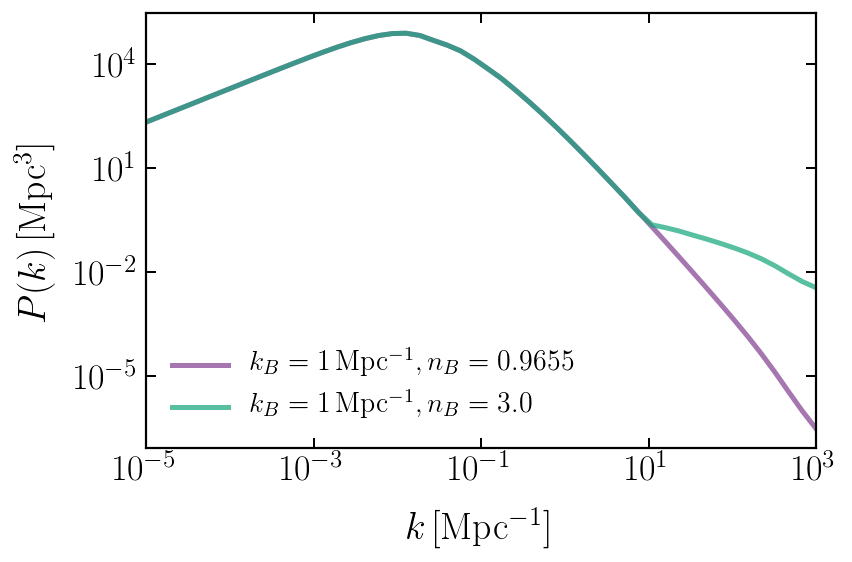

In [557]:
for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    k_ary = np.logspace(-5, np.log10(1000))
    pk_ary = np.array([CLASS_inst.pk_lin(k,0) for k in k_ary])
    plt.plot(k_ary, pk_ary, label="$k_B=1\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$\,[Mpc$^{-1}$]")
plt.ylabel("$P(k)$\,[Mpc$^{3}$]")
plt.xlim(min(k_ary), max(k_ary))
plt.legend(fontsize=14)

## Press-Schechter, manual

In [558]:
def dn_dM_s(M_sc, CLASS_inst):
    R = (M_sc / (4 / 3. * np.pi * rho_m)) ** (1 / 3.)
    sigma = CLASS_inst.sigma(R / Mpc, 0) 
    sigma_log_deriv = np.abs(M_sc * derivative(lambda M: np.log(CLASS_inst.sigma((M / (4 / 3. * np.pi * rho_m)) ** (1 / 3.) / Mpc, 0)), x0=M_sc, dx=(0.9) * M_sc))
    return np.sqrt(2 / np.pi) * rho_m / M_sc ** 2 * delta_c / sigma * sigma_log_deriv * np.exp(-delta_c ** 2 / (2 * sigma ** 2))

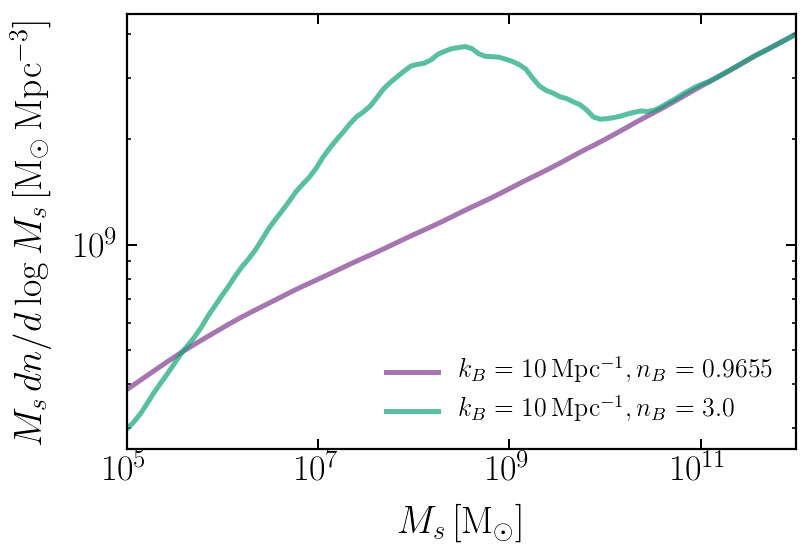

In [559]:
M_ary = np.logspace(5, 12, 100) * M_s

for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    plt.plot(M_ary / M_s, [M ** 2 * mfk.dn_dM_s(M, CLASS_inst) / (Mpc ** -3) / M_s for M in M_ary], label="$k_B=10\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$M_s$\,[M$_\odot$]")
plt.ylabel("$M_s\, dn/d\log M_s\,[\mathrm{M_\odot}$\,Mpc$^{-3}$]")
plt.xlim(min(M_ary / M_s), max(M_ary / M_s))
plt.legend(fontsize=13)

## Mass functions from `colossus`

In [560]:
import random, string

def randomword(length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

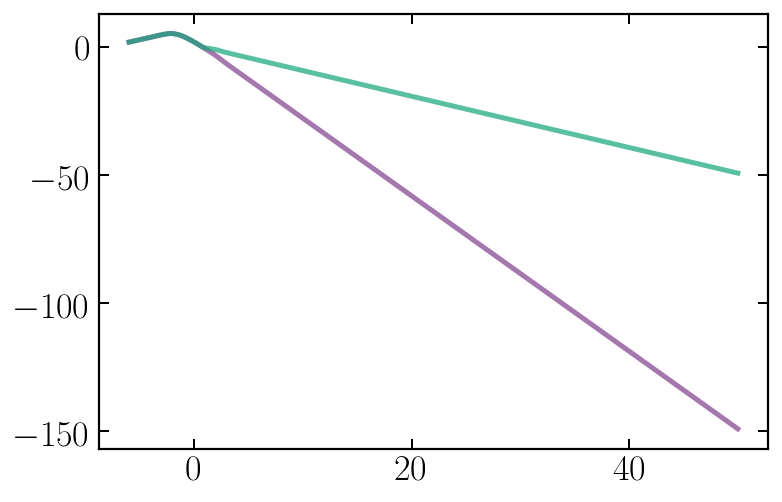

In [573]:
k_ary = np.logspace(-6, np.log10(1e3), 10000)
Pk_ary_base = np.array([CLASS_inst_list[0].pk_lin(k,0) for k in k_ary])
Pk_ary = np.array([CLASS_inst_list[1].pk_lin(k,0) for k in k_ary])

log10_k_interp_ary = np.linspace(-6, 50, 10000)

log10_P_interp = interp1d(np.log10(k_ary * h), np.log10(Pk_ary_base / h ** 3), bounds_error=False, fill_value='extrapolate')
log10_P_interp_ary = (log10_P_interp)(log10_k_interp_ary)
np.savetxt("/Users/smsharma/Desktop/pk_base.dat", np.transpose([log10_k_interp_ary, log10_P_interp_ary]),
           delimiter='\t')

plt.plot(log10_k_interp_ary, log10_P_interp_ary)

log10_P_interp = interp1d(np.log10(k_ary * h), np.log10(Pk_ary / h ** 3), bounds_error=False, fill_value='extrapolate')
log10_P_interp_ary = (log10_P_interp)(log10_k_interp_ary)
np.savetxt("/Users/smsharma/Desktop/pk.dat", np.transpose([log10_k_interp_ary, log10_P_interp_ary]),
           delimiter='\t')

plt.plot(log10_k_interp_ary, log10_P_interp_ary)

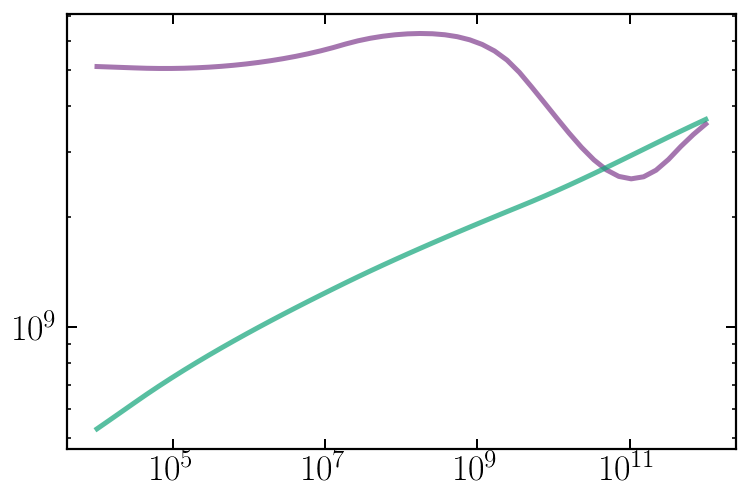

In [576]:
cosmo = cosmology.setCosmology('planck18')

M_ary = np.logspace(4,12)

# mf0 = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM')

# mf1 = mass_function.massFunction(M_ary, 0.0, mdef = 'fof', model = 'press74', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk.dat"})
mf1 = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk.dat"})


# mf2 = mass_function.massFunction(M_ary, 0.0, mdef = 'fof', model = 'press74', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk_base.dat"})
mf2 = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk_base.dat"})

# plt.plot(M_ary, M_ary * mf0)
plt.plot(M_ary, M_ary * mf1)
plt.plot(M_ary, M_ary * mf2)

plt.xscale("log")
plt.yscale("log")